# Development Notebook for Cortical Crowding Project

In [1]:
import os, sys
from pathlib import Path

import numpy as np
import pandas as pd
import neuropythy as ny
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.optimize
from scipy.stats import gmean
from scipy.optimize import curve_fit

In [2]:
# We want to be able to load in libraries that are in this repository's src directory,
# so we add src to the system path:
sys.path.append('../src')

# Now we can import corticalcrowding from the src directory:
import corticalcrowding as cc

In [3]:
df = pd.read_csv('/data/crowding/crowding_data_withID.csv')

In [4]:
sids = [
    'sub-wlsubj119',
    'sub-wlsubj127',
    'sub-wlsubj136',
    'sub-wlsubj137',
    'sub-wlsubj143',
    'sub-wlsubj144',
    'sub-wlsubj145',
    'sub-wlsubj146',
    'sub-wlsubj147',
    'sub-wlsubj148',
    'sub-wlsubj149',
    'sub-wlsubj150',
    'sub-wlsubj151',
    'sub-wlsubj152',
    'sub-wlsubj153',
    'sub-wlsubj154',
    'sub-wlsubj155',
    'sub-wlsubj156',
    'sub-wlsubj157',
    'sub-wlsubj158',
    'sub-wlsubj159',
    'sub-wlsubj160',
    'sub-wlsubj161',
    'sub-wlsubj162',
    'sub-wlsubj163',
    'sub-wlsubj164',
    'sub-wlsubj165',
    'sub-wlsubj166',
    'sub-wlsubj167',
    'sub-wlsubj168',
    'sub-wlsubj170',
    'sub-wlsubj171',
    'sub-wlsubj172',
    'sub-wlsubj173',
    'sub-wlsubj174',
    'sub-wlsubj175',
    'sub-wlsubj176']

## crowding

NameError: name 'popt1' is not defined

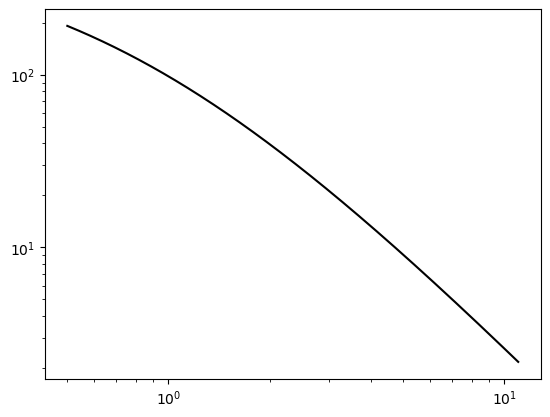

In [191]:
eccen = np.linspace(0.5, 11, 1000)
plt.loglog(eccen, cc.cmag.HH91(eccen),'k-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt1),'b-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt2),'r-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt3),'c-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt4),'g-')

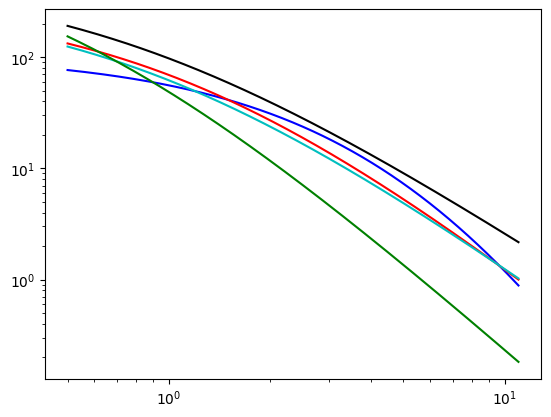

In [57]:
eccen = np.linspace(0.5, 11, 1000)
plt.loglog(eccen, cc.cmag.HH91(eccen),'k-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt1_3params),'b-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt2_3params),'r-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt3_3params),'c-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt4_3params),'g-')

In [71]:
mean_cd_polar = df.groupby(['ID','Eccen_X','Eccen_Y'])['CrowdingDistance'].apply(gmean).reset_index()

In [72]:
mean_cd_polar

,ID,Eccen_X,Eccen_Y,CrowdingDistance
0,sub-wlsubj001,-10.0,0.0,3.757971
1,sub-wlsubj001,-5.0,0.0,1.905962
2,sub-wlsubj001,-2.5,0.0,0.777402
3,sub-wlsubj001,0.0,-10.0,4.115811
4,sub-wlsubj001,0.0,-5.0,1.917689
...,...,...,...,...
235,sub-wlsubj158,0.0,5.0,1.284848
236,sub-wlsubj158,0.0,10.0,3.560097
237,sub-wlsubj158,2.5,0.0,0.329442
238,sub-wlsubj158,5.0,0.0,0.828792


In [7]:
# each subject has 1 cd value at each eccentricity
mean_cd = df.groupby(['ID','RadialEccentricity'])['CrowdingDistance'].apply(gmean).reset_index()

In [8]:
cd_list = df['CrowdingDistance'].tolist()
mean_cd_list=mean_cd['CrowdingDistance'].tolist()

In [9]:
# create 3 dfs based on eccen
mean_1 = mean_cd[mean_cd['RadialEccentricity']==2.5]
m_1 = mean_1['CrowdingDistance'].mean()
st_1 = mean_1['CrowdingDistance'].std()
mean_2 = mean_cd[mean_cd['RadialEccentricity']==5]
m_2 = mean_2['CrowdingDistance'].mean()
st_2 = mean_2['CrowdingDistance'].std()
mean_3 = mean_cd[mean_cd['RadialEccentricity']==10]
m_3 = mean_3['CrowdingDistance'].mean()
st_3 = mean_3['CrowdingDistance'].std()

In [10]:
x_ecc = df['RadialEccentricity'].tolist()
mean_x_ecc = mean_cd['RadialEccentricity'].tolist()

In [11]:
b, _ = curve_fit(cc.crowding.func_cd, x_ecc, np.log10(cd_list), p0=0.15)
b

array([0.19811346])

In [12]:
mean_values = [m_1, m_2, m_3]
std_values = [st_1, st_2, st_3]
eccentricities = [2.5, 5, 10]

In [13]:
mean_values

[0.6885809437409106, 1.3966182263508535, 3.422964015001243]

## calculate cortical magnification

In [6]:
eccen = np.linspace(1, 11, 1000)

In [7]:
all_cmag_v1 = []
all_cmag_v2 = []
all_cmag_v3 = []
all_cmag_v4 = []
all_eccen_v1 = []
all_eccen_v2 = []
all_eccen_v3 = []
all_eccen_v4 = []
all_mask = ('variance_explained', 0.04, 1)

for sid in sids:
    try:
        sub = cc.cmag.load_subject(sid)

        # Calculate cmag for the subject for V1
        v1_mask = {'and': [('visual_area', 1), all_mask]}
        eccen_v1, cmag_v1 = cc.cmag.ring_cmag(sub, eccen=None, mask=v1_mask)
        all_eccen_v1.append(eccen_v1)
        all_cmag_v1.append(cmag_v1)

        # Calculate cmag for the subject for V2
        v2_mask = {'and': [('visual_area', 2), all_mask]}
        eccen_v2, cmag_v2 = cc.cmag.ring_cmag(sub, eccen=None, mask=v2_mask)
        all_eccen_v2.append(eccen_v2)
        all_cmag_v2.append(cmag_v2)

        # Calculate cmag for the subject for V3
        v3_mask = {'and': [('visual_area', 3), all_mask]}
        eccen_v3, cmag_v3 = cc.cmag.ring_cmag(sub, eccen=None, mask=v3_mask)
        all_eccen_v3.append(eccen_v3)
        all_cmag_v3.append(cmag_v3)
        
        # Calculate cmag for the subject for V4
        v4_mask = {'and': [('visual_area', 4), all_mask]}
        eccen_v4, cmag_v4 = cc.cmag.ring_cmag(sub, eccen=None, mask=v4_mask)
        all_eccen_v4.append(eccen_v4)
        all_cmag_v4.append(cmag_v4)
        
    
    except Exception as e:
        print(f"Error calculating cmag for subject {sid}: {e}")

all_flatcmag_v1 = np.concatenate(all_cmag_v1)
all_flateccen_v1 = np.concatenate(all_eccen_v1)
all_flatcmag_v2 = np.concatenate(all_cmag_v2)
all_flateccen_v2 = np.concatenate(all_eccen_v2)
all_flatcmag_v3 = np.concatenate(all_cmag_v3)
all_flateccen_v3 = np.concatenate(all_eccen_v3)
all_flatcmag_v4 = np.concatenate(all_cmag_v4)
all_flateccen_v4 = np.concatenate(all_eccen_v4)

Error calculating cmag for subject sub-wlsubj161: Could not interpret source path: /data/NYUNEI/derivatives/prfvista/sub-wlsubj161/ses-nyu3t01/lh.angle_adj.mgz
Error calculating cmag for subject sub-wlsubj171: Could not interpret source path: /data/NYUNEI/derivatives/rois/Linda_rh.sub-wlsubj171.ROIs_V1-4.mgz


[15.917919101867323, 1.134882418511627] [18.675160865422296, 8.092211760510644, 5.590390872060128]


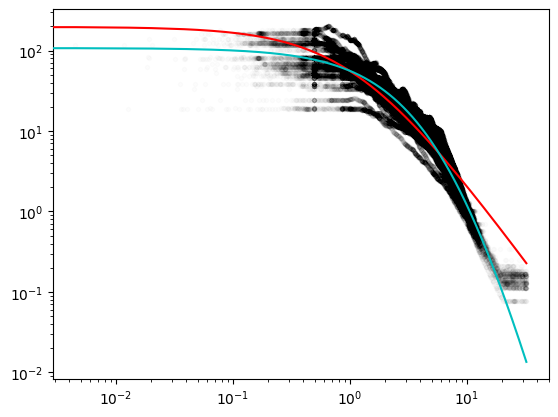

In [16]:
ii = (all_flateccen_v1 < 11) & (all_flatcmag_v1 > 0) & (all_flateccen_v1 > 0.2)
popt1 = cc.cmag.fit_cmag(all_flateccen_v1[ii], all_flatcmag_v1[ii],method='BFGS')
popt1_3params = cc.cmag.fit_cmag(all_flateccen_v1[ii], all_flatcmag_v1[ii],p0=[17.3,0.75,2],method='BFGS')
print(popt1,popt1_3params)
plt.loglog(all_flateccen_v1,all_flatcmag_v1,'k.',alpha=0.01) 
plot_ecc = np.sort(all_flateccen_v1)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt1),'r-', zorder=10)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt1_3params),'c-', zorder=10)
plt.show()

[12.918835432299513, 0.6121518291248482] [12.125505346744957, 1.133572206515478, 2.4400863155310852]


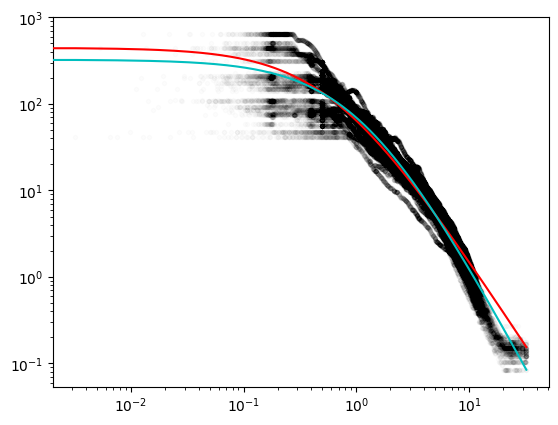

In [17]:
ii = (all_flateccen_v2 < 11) & (all_flatcmag_v2 > 0) & (all_flateccen_v2 > 0.2)
popt2 = cc.cmag.fit_cmag(all_flateccen_v2[ii], all_flatcmag_v2[ii],method='BFGS')
popt2_3params = cc.cmag.fit_cmag(all_flateccen_v2[ii], all_flatcmag_v2[ii],p0=[17.3,0.75,2],method='BFGS')
print(popt2,popt2_3params)
plt.loglog(all_flateccen_v2,all_flatcmag_v2,'k.',alpha=0.01) 
plot_ecc = np.sort(all_flateccen_v2)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt2),'r-', zorder=10)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt2_3params),'c-', zorder=10)
plt.show()

[12.368576982410717, 0.735256194019073] [11.965907429471981, 0.8431107306678487, 2.2071157163780293]


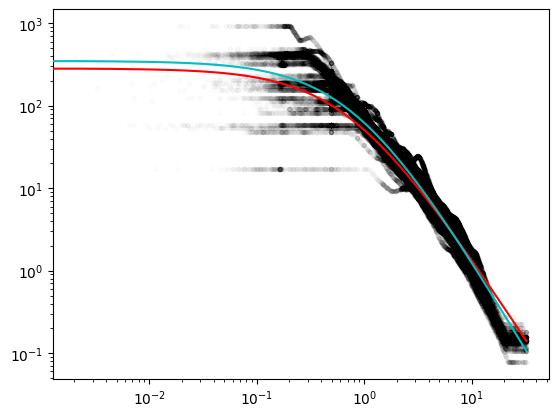

In [18]:
ii = (all_flateccen_v3 < 11) & (all_flatcmag_v3 > 0) & (all_flateccen_v3 > 0.2)
popt3 = cc.cmag.fit_cmag(all_flateccen_v3, all_flatcmag_v3,method='BFGS')
popt3_3params = cc.cmag.fit_cmag(all_flateccen_v3[ii], all_flatcmag_v3[ii],p0=[17.3,0.75,2],method='BFGS')
print(popt3,popt3_3params)
plt.loglog(all_flateccen_v3,all_flatcmag_v3,'k.',alpha=0.01) 
plot_ecc = np.sort(all_flateccen_v3)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt3),'r-', zorder=10)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt3_3params),'c-', zorder=10)
plt.show()

[7.3578056009819, 0.11443766963045292] [6.084191267694632, 0.44256211004598595, 2.701490783199254]


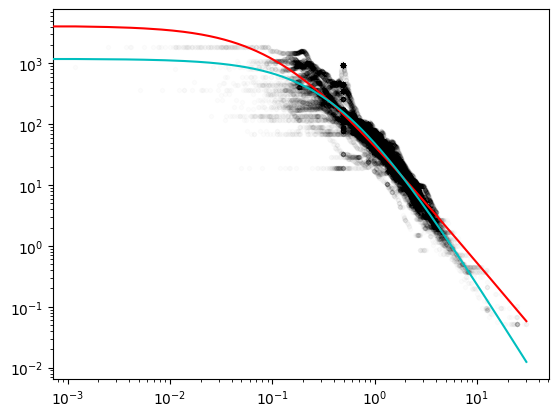

In [19]:
ii = (all_flateccen_v4 < 11) & (all_flatcmag_v4 > 0) & (all_flateccen_v4 > 0.2)
popt4 = cc.cmag.fit_cmag(all_flateccen_v4[ii], all_flatcmag_v4[ii],method='BFGS')
popt4_3params = cc.cmag.fit_cmag(all_flateccen_v4[ii], all_flatcmag_v4[ii],p0=[17.3,0.75,2],method='BFGS')
print(popt4,popt4_3params)
plt.loglog(all_flateccen_v4,all_flatcmag_v4,'k.',alpha=0.01) 
plot_ecc = np.sort(all_flateccen_v4)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt4),'r-', zorder=10)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt4_3params),'c-', zorder=10)
plt.show()

## add cortical magnification values to df

In [123]:
# magnification_values is a dict containing cmag for each visual area
magnification_values = cc.cmag.calculate_cortical_magnification(df)

for mask_value in [1, 2, 3, 4]:
    col_name = f'CorticalMagnification_{mask_value}'
    df.loc[:, col_name] = magnification_values[mask_value]

In [124]:
df_sub_polar = df.groupby(['Eccen_X','Eccen_Y','ID'])[[
    'CorticalMagnification_1',
    'CorticalMagnification_2',
    'CorticalMagnification_3',
    'CorticalMagnification_4'
]].mean().reset_index()

In [128]:
df_cell = df_sub_polar
# convert 2d cortical magnification into 1d visual magnification and change the names of columns accordingly
for col in ['CorticalMagnification_1', 'CorticalMagnification_2', 'CorticalMagnification_3', 'CorticalMagnification_4']:
    df_cell[col] = np.sqrt(1 / df_cell[col])
df_cell.rename(columns={
    'CorticalMagnification_1': 'VisualMagnification_1',
    'CorticalMagnification_2': 'VisualMagnification_2',
    'CorticalMagnification_3': 'VisualMagnification_3',
    'CorticalMagnification_4': 'VisualMagnification_4'
}, inplace=True)

In [129]:
# sort the df
df_cell.sort_values(by=['ID', 'Eccen_X','Eccen_Y'], inplace=True)
# add the crowding values to the df
mean_for_sub = mean_cd_polar['CrowdingDistance'].values
df_cell['CrowdingDistance'] = mean_for_sub

In [130]:
# drop nan values
df_sub_clean = df_cell.dropna(subset=['VisualMagnification_1'])

In [131]:
df_sub_clean

,Eccen_X,Eccen_Y,ID,VisualMagnification_1,VisualMagnification_2,VisualMagnification_3,VisualMagnification_4,CrowdingDistance
7,-10.0,0.0,sub-wlsubj119,0.694739,0.730484,0.615743,1.118104,2.036438
27,-5.0,0.0,sub-wlsubj119,0.256535,0.319813,0.269456,0.503608,1.138215
47,-2.5,0.0,sub-wlsubj119,0.113672,0.170025,0.152202,0.230195,0.471992
67,0.0,-10.0,sub-wlsubj119,0.802788,0.627297,0.751288,1.323953,2.431845
87,0.0,-5.0,sub-wlsubj119,0.374613,0.238622,0.349528,0.677818,1.112197
...,...,...,...,...,...,...,...,...
159,0.0,5.0,sub-wlsubj158,0.419687,0.401527,0.505596,0.622815,1.284848
179,0.0,10.0,sub-wlsubj158,0.895694,0.801700,0.995668,1.367272,3.560097
199,2.5,0.0,sub-wlsubj158,0.165227,0.237089,0.217647,0.235346,0.329442
219,5.0,0.0,sub-wlsubj158,0.296965,0.438190,0.327363,0.517272,0.828792


## plot visual magnification and crowding values 

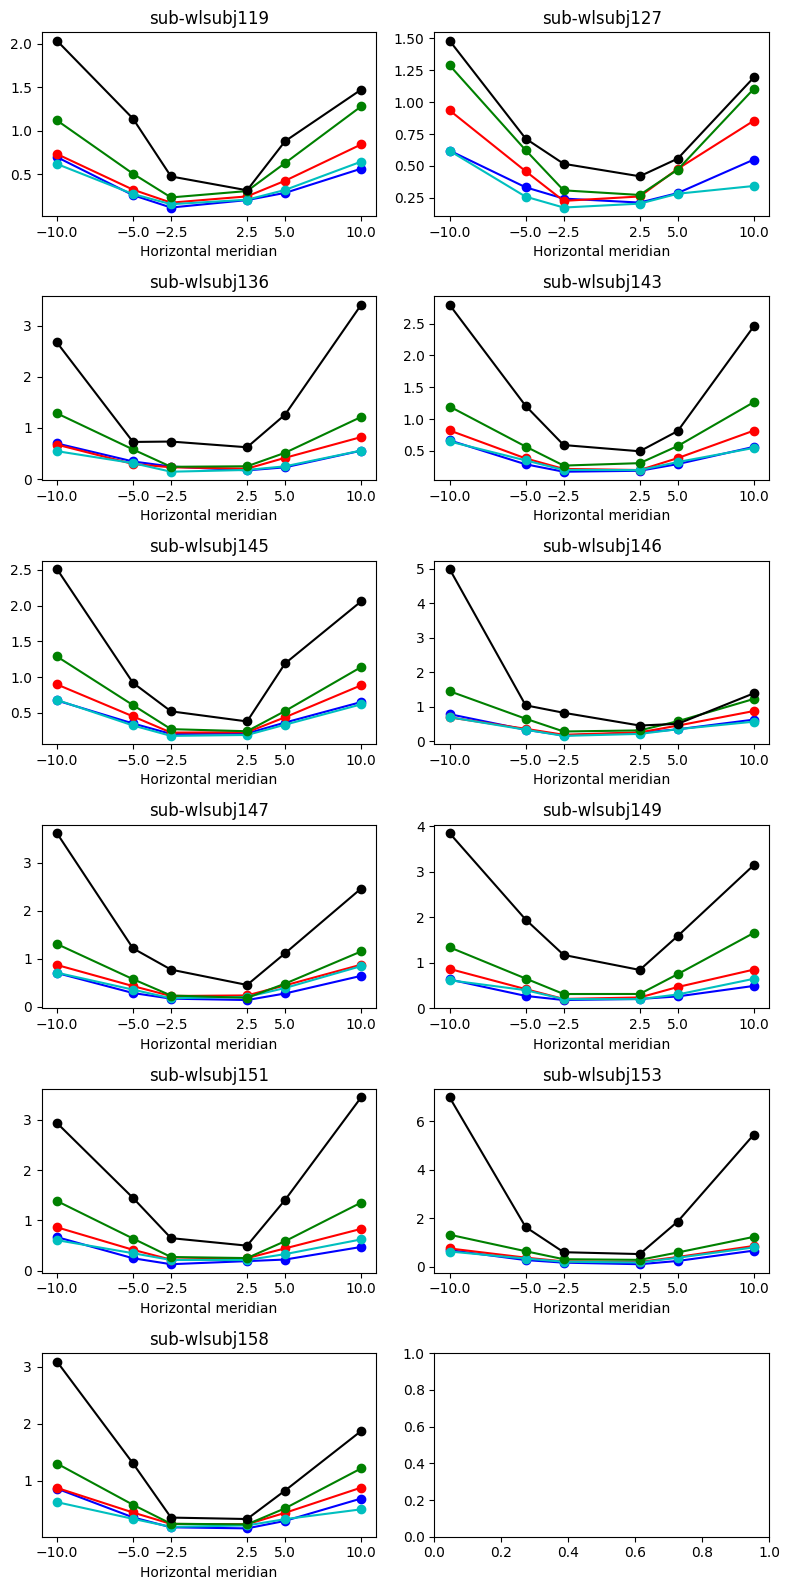

In [132]:
sids = np.unique(df_sub_clean['ID'])
fig, axes = plt.subplots((len(sids)+1)//2,2, figsize=(8,16))
x_ticks = [-10, -5, -2.5, 2.5, 5, 10]
for sid, ax in zip(sids, axes.flat):
    subject_data = df_sub_clean[(df_sub_clean['ID']==sid) & (df_sub_clean['Eccen_Y']==0)]
    y1 = subject_data['VisualMagnification_1'].values
    y2 = subject_data['VisualMagnification_2'].values
    y3 = subject_data['VisualMagnification_3'].values
    y4 = subject_data['VisualMagnification_4'].values
    y5 = subject_data['CrowdingDistance'].values
    
    ax.plot(subject_data['Eccen_X'], y1, 'bo-')
    ax.plot(subject_data['Eccen_X'], y2, 'ro-')
    ax.plot(subject_data['Eccen_X'], y3, 'co-')
    ax.plot(subject_data['Eccen_X'], y4, 'go-')
    ax.plot(subject_data['Eccen_X'], y5, 'ko-')
    
    ax.set_xticks(x_ticks)
    ax.set_title(sid)
    ax.set_xlabel("Horizontal meridian")
    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

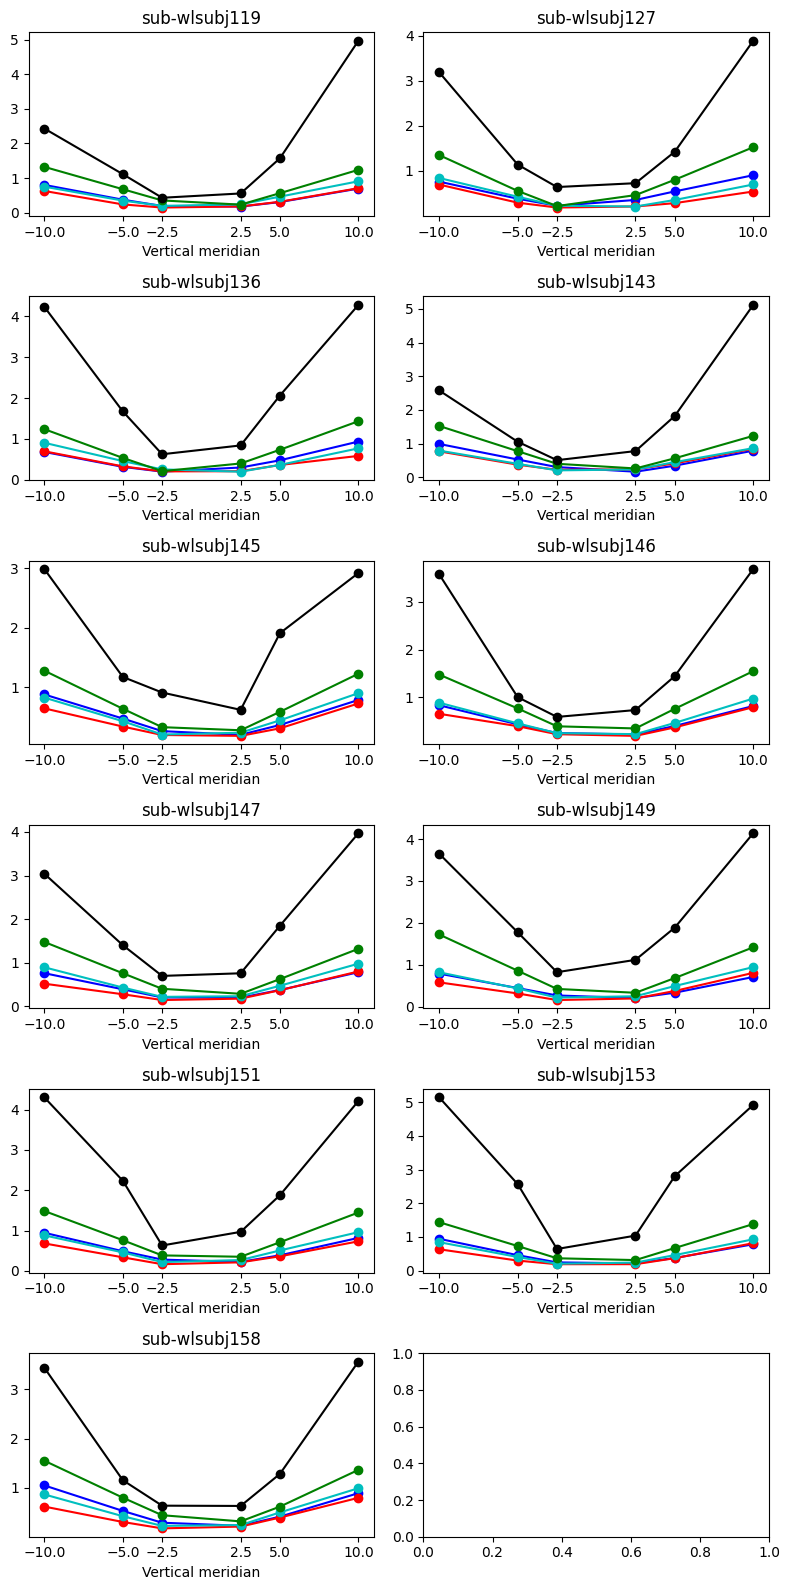

In [134]:
sids = np.unique(df_sub_clean['ID'])
fig, axes = plt.subplots((len(sids)+1)//2,2, figsize=(8,16))
x_ticks = [-10, -5, -2.5, 2.5, 5, 10]

for sid, ax in zip(sids, axes.flat):
    subject_data = df_sub_clean[(df_sub_clean['ID']==sid) & (df_sub_clean['Eccen_X']==0)]
    y1 = subject_data['VisualMagnification_1'].values
    y2 = subject_data['VisualMagnification_2'].values
    y3 = subject_data['VisualMagnification_3'].values
    y4 = subject_data['VisualMagnification_4'].values
    y5 = subject_data['CrowdingDistance'].values
    
    ax.plot(subject_data['Eccen_Y'], y1, 'bo-')
    ax.plot(subject_data['Eccen_Y'], y2, 'ro-')
    ax.plot(subject_data['Eccen_Y'], y3, 'co-')
    ax.plot(subject_data['Eccen_Y'], y4, 'go-')
    ax.plot(subject_data['Eccen_Y'], y5, 'ko-')
    
    ax.set_xticks(x_ticks)
    ax.set_title(sid)
    ax.set_xlabel("Vertical meridian")
    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## use cortical magnification to predict crowding

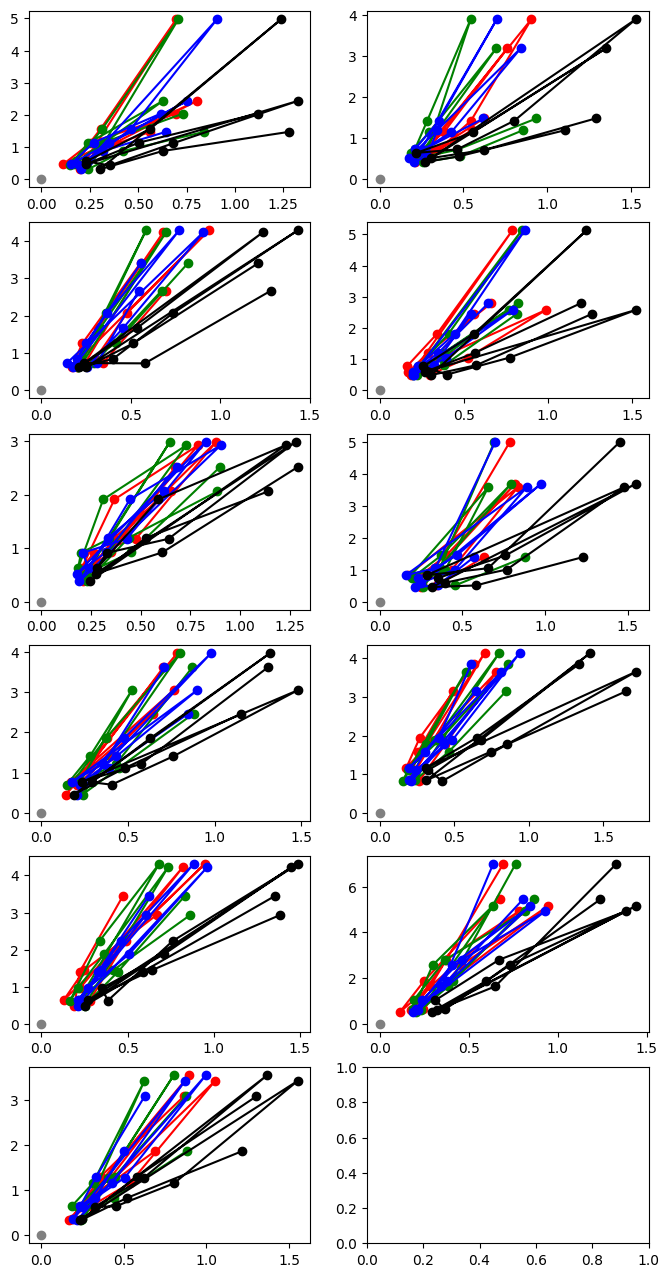

In [77]:
sids = np.unique(df_sub_clean['ID'])

fig, axes = plt.subplots((len(sids)+1)//2,2, figsize=(8,16))

for sid, ax in zip(sids, axes.flat):
    subject_data = df_sub_clean[df_sub_clean['ID']==sid]
    y1 = subject_data['VisualMagnification_1'].values
    y2 = subject_data['VisualMagnification_2'].values
    y3 = subject_data['VisualMagnification_3'].values
    y4 = subject_data['VisualMagnification_4'].values
    y5 = subject_data['CrowdingDistance'].values

    rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
    rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
    rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
    rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)

    ax.plot(y1, y5, 'ro-')
    ax.plot(y2, y5, 'go-')
    ax.plot(y3, y5, 'bo-')
    ax.plot(y4, y5, 'ko-')
    ax.scatter([0],[0],color = '0.5')
#ax.axis('equal')

In [89]:
grouped = df_sub_clean.groupby('ID')
subject_results = {}

# Iterate over each subject to do the regression
for subject, subject_data in grouped:
    y1 = subject_data['VisualMagnification_1'].values
    y2 = subject_data['VisualMagnification_2'].values
    y3 = subject_data['VisualMagnification_3'].values
    y4 = subject_data['VisualMagnification_4'].values
    y5 = subject_data['CrowdingDistance'].values

    
    rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
    rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
    rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
    rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)
    
    rss_values = [rss_y1, rss_y2, rss_y3, rss_y4]
    best_fit_index = np.argmin(rss_values)
    best_fit = ['y1','y2','y3','y4'][best_fit_index]
    
    # create a dict to store values
    subject_results[subject] = {
        'rss_y1': rss_y1, 'coef_y1': coef_y1,
        'rss_y2': rss_y2, 'coef_y2': coef_y2,
        'rss_y3': rss_y3, 'coef_y3': coef_y3,
        'rss_y4': rss_y4, 'coef_y4': coef_y4,
        'best_fit': best_fit
    }

for subject, results in subject_results.items():
    print(f"Results for {subject}:")
    print(f"RSS for y1: {results['rss_y1']}, Coefficient: {results['coef_y1']}")
    print(f"RSS for y2: {results['rss_y2']}, Coefficient: {results['coef_y2']}")
    print(f"RSS for y3: {results['rss_y3']}, Coefficient: {results['coef_y3']}")
    print(f"RSS for y4: {results['rss_y4']}, Coefficient: {results['coef_y4']}")
    print(f"The best fit is: {results['best_fit']}\n")


Results for sub-wlsubj119:
RSS for y1: 7.202182863138589, Coefficient: 3.8663026910459255
RSS for y2: 9.673863204838948, Coefficient: 3.531616739948601
RSS for y3: 4.164281706221712, Coefficient: 3.7155654440039028
RSS for y4: 7.954425598783317, Coefficient: 2.119017151997312
The best fit is: y3

Results for sub-wlsubj127:
RSS for y1: 2.8187185164514887, Coefficient: 3.246911230786349
RSS for y2: 11.45689846983967, Coefficient: 2.689347279249771
RSS for y3: 3.0582418986841753, Coefficient: 3.681497311343201
RSS for y4: 3.548972157839616, Coefficient: 1.851258932989368
The best fit is: y1

Results for sub-wlsubj136:
RSS for y1: 3.5893406396044343, Coefficient: 4.683205839343136
RSS for y2: 5.083877856708642, Coefficient: 4.813678509730748
RSS for y3: 2.269653826700494, Coefficient: 4.882175033649352
RSS for y4: 2.4314477588583725, Coefficient: 2.7431339365435927
The best fit is: y3

Results for sub-wlsubj143:
RSS for y1: 7.784600509255465, Coefficient: 3.8915251274089897
RSS for y2: 5.2

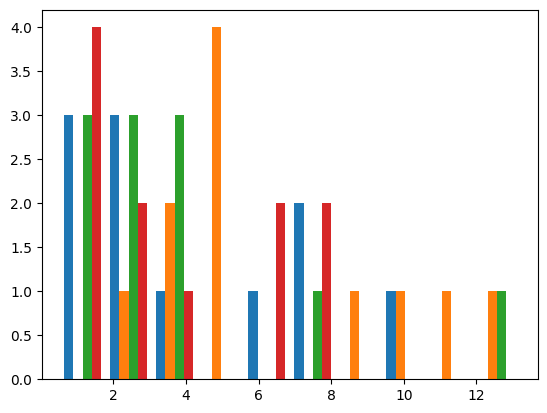

In [90]:
key = 'rss_y1'
data = [[subdata[key] for subdata in subject_results.values()]
        for key in ['rss_y1','rss_y2','rss_y3','rss_y4']]
plt.hist(data)
plt.show()

In [91]:
rss_y1_values = []
rss_y2_values = []
rss_y3_values = []
rss_y4_values = []

for subject, values in subject_results.items():
    rss_y1_values.append(values['rss_y1'])
    rss_y2_values.append(values['rss_y2'])
    rss_y3_values.append(values['rss_y3'])
    rss_y4_values.append(values['rss_y4'])

mean_rss_y1 = np.mean(rss_y1_values)
mean_rss_y2 = np.mean(rss_y2_values)
mean_rss_y3 = np.mean(rss_y3_values)
mean_rss_y4 = np.mean(rss_y4_values)

std_rss_y1 = np.std(rss_y1_values)
std_rss_y2 = np.std(rss_y2_values)
std_rss_y3 = np.std(rss_y3_values)
std_rss_y4 = np.std(rss_y4_values)

# Print results
print(f"Mean RSS for y1: {mean_rss_y1}, Standard Deviation: {std_rss_y1}")
print(f"Mean RSS for y2: {mean_rss_y2}, Standard Deviation: {std_rss_y2}")
print(f"Mean RSS for y3: {mean_rss_y3}, Standard Deviation: {std_rss_y3}")
print(f"Mean RSS for y4: {mean_rss_y4}, Standard Deviation: {std_rss_y4}")

Mean RSS for y1: 4.160937106839729, Standard Deviation: 3.0021302528699985
Mean RSS for y2: 6.601651679589349, Standard Deviation: 3.417085104232759
Mean RSS for y3: 3.649551211733012, Standard Deviation: 3.2531542415814805
Mean RSS for y4: 3.8823011587794043, Standard Deviation: 2.6165403024445015


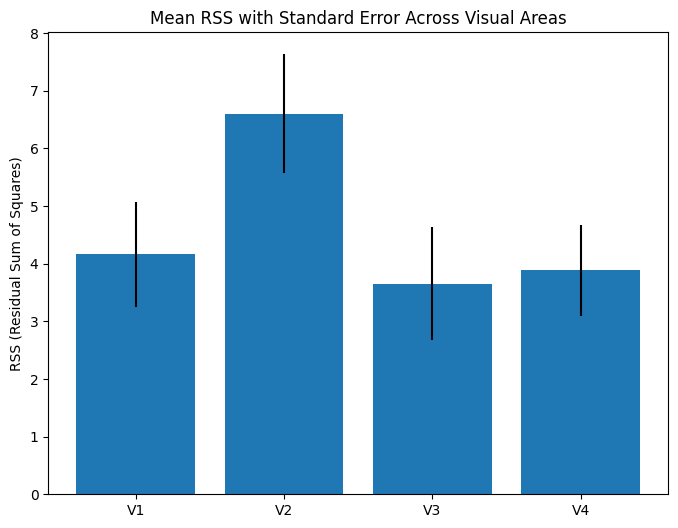

In [92]:
mean_rss = [mean_rss_y1, mean_rss_y2, mean_rss_y3, mean_rss_y4]
std_rss = [std_rss_y1, std_rss_y2, std_rss_y3, std_rss_y4]

labels = ['V1', 'V2', 'V3', 'V4']

plt.figure(figsize=(8, 6))
plt.bar(labels, mean_rss, yerr=std_rss/np.sqrt(len(sids)))

plt.ylabel('RSS (Residual Sum of Squares)')
plt.title('Mean RSS with Standard Error Across Visual Areas')
plt.show()

In [42]:
## look at group data

In [37]:
grouped_df = df.groupby('RadialEccentricity')[[
    'CorticalMagnification_1',
    'CorticalMagnification_2',
    'CorticalMagnification_3',
    'CorticalMagnification_4'
]].mean().reset_index()

# make it 1d visual magnification
for col in ['CorticalMagnification_1', 'CorticalMagnification_2', 'CorticalMagnification_3', 'CorticalMagnification_4']:
    grouped_df[col] = np.sqrt(1 / grouped_df[col])

In [38]:
grouped_df['CrowdingDistance'] = mean_values
grouped_df.rename(columns={
    'CorticalMagnification_1': 'VisualMagnification_1',
    'CorticalMagnification_2': 'VisualMagnification_2',
    'CorticalMagnification_3': 'VisualMagnification_3',
    'CorticalMagnification_4': 'VisualMagnification_4'
}, inplace=True)
grouped_df

,RadialEccentricity,VisualMagnification_1,VisualMagnification_2,VisualMagnification_3,VisualMagnification_4,CrowdingDistance
0,2.5,0.192802,0.202510,0.204179,0.286848,0.688581
1,5.0,0.328445,0.362106,0.364464,0.617238,1.396618
2,10.0,0.703470,0.740332,0.691151,1.324307,3.422964


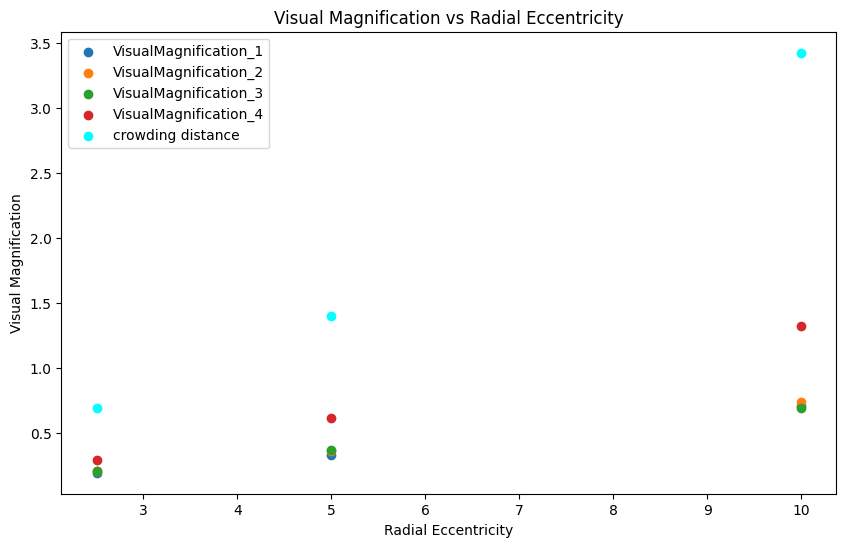

In [39]:
plt.figure(figsize=(10, 6))
for col in ['VisualMagnification_1', 'VisualMagnification_2', 'VisualMagnification_3', 'VisualMagnification_4']:
    plt.scatter(grouped_df['RadialEccentricity'], grouped_df[col], marker='o', linestyle='-', label=col)
plt.scatter(eccentricities, mean_values, color='cyan', label = 'crowding distance')
plt.xlabel('Radial Eccentricity')
plt.ylabel('Visual Magnification')
plt.title('Visual Magnification vs Radial Eccentricity')
plt.legend()
plt.show()

In [40]:
y1 = grouped_df['VisualMagnification_1'].values
y2 = grouped_df['VisualMagnification_2'].values
y3 = grouped_df['VisualMagnification_3'].values
y4 = grouped_df['VisualMagnification_4'].values
y5 = grouped_df['CrowdingDistance'].values

rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)

rss_values = [rss_y1, rss_y2, rss_y3, rss_y4]
best_fit_index = np.argmin(rss_values)
best_fit = ['y1', 'y2', 'y3', 'y4'][best_fit_index]

print(f"RSS for y1: {rss_y1}, Coefficient: {coef_y1}")
print(f"RSS for y2: {rss_y2}, Coefficient: {coef_y2}")
print(f"RSS for y3: {rss_y3}, Coefficient: {coef_y3}")
print(f"RSS for y4: {rss_y4}, Coefficient: {coef_y4}")
print(f"The best fit is: {best_fit}")

RSS for y1: 0.08247822520101082, Coefficient: 4.687195783310704
RSS for y2: 0.1069049814837579, Coefficient: 4.41433074562412
RSS for y3: 0.2001923477759463, Coefficient: 4.623331017885218
RSS for y4: 0.033731619771933, Coefficient: 2.522546003159664
The best fit is: y4


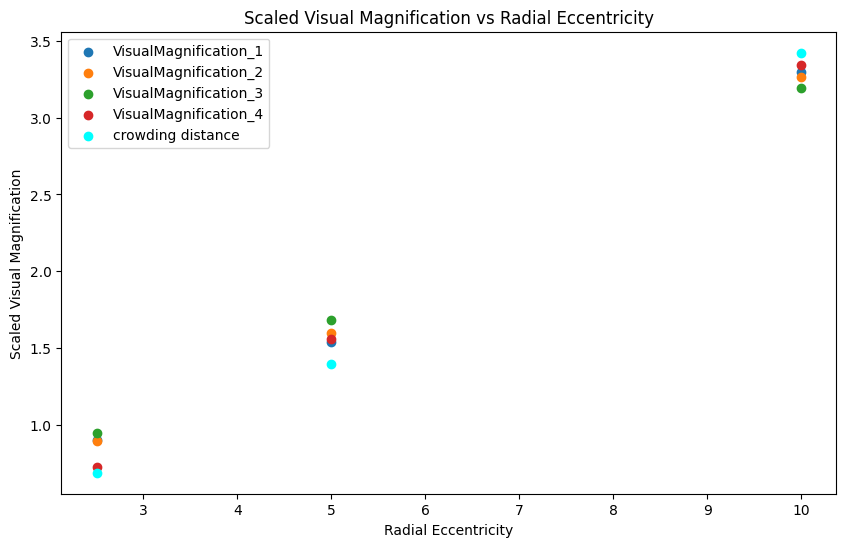

In [41]:
plt.figure(figsize=(10, 6))
for scale, col in zip([coef_y1,coef_y2,coef_y3,coef_y4],['VisualMagnification_1', 'VisualMagnification_2', 'VisualMagnification_3', 'VisualMagnification_4']):
    plt.scatter(grouped_df['RadialEccentricity'], scale * grouped_df[col], marker='o', linestyle='-', label=col)
plt.scatter(eccentricities, mean_values, color='cyan', label = 'crowding distance')
plt.xlabel('Radial Eccentricity')
plt.ylabel('Scaled Visual Magnification')
plt.title('Scaled Visual Magnification vs Radial Eccentricity')
plt.legend()
plt.show()

## Testing alternative fitting

In [74]:
def HH91_vmag(ecc, a=17.3, b=0.75, c=2):
    return ((np.asarray(ecc) + b) / a)**c
def fit_vmag(ecc, cmag, params0=(17.3, 0.75), method=None):
    from scipy.optimize import minimize
    ecc = np.asarray(ecc, dtype=np.float64)
    cmag = np.asarray(cmag, dtype=np.float64)
    vmag = 1/cmag
    def loss_vmag(params):
        params = list(params)
        params[1] = params[1]**2
        pred = HH91_vmag(ecc, *params)
        error = (pred - vmag)
        return np.sum(error**2)
    params0 = list(params0)
    params0[1] = np.sqrt(params0[1])
    r = minimize(loss_vmag, params0, method=method)
    r.x[1] = r.x[1]**2
    r.coords = np.array([ecc,cmag])
    return r
def trimsame(x, *args):
    x = np.asarray(x)
    idx0 = np.where(x != x[0])[0][0] - 1
    idxn = np.where(~np.isclose(x, x[-1]))[0][-1] + 1
    return (x[idx0:idxn],) + tuple(arg[idx0:idxn] for arg in args)
def fit_subject_vmag(sid,
                     params0=(17.3, 0.75),
                     method=None,
                     allmask={'and': [('variance_explained', 0.04, 1),
                                      ('eccentricity', 0, 12)]}):
    sub = cc.cmag.load_subject(sid)
    cmags = []
    eccens = []
    results = []
    for k in range(1,5):
        mask = {'and': [('visual_area', k), allmask]}
        eccen, cmag = cc.cmag.ring_cmag(sub, mask=mask)
        (cmag, eccen) = trimsame(cmag, eccen)
        eccens.append(eccen)
        cmags.append(cmag)
        results.append(fit_vmag(eccen, cmag, params0, method=method))
    return results

In [65]:
rs = fit_subject_vmag('sub-wlsubj150')

trimming: 289 3122
trimming: 242 3092
trimming: 45 3387
trimming: 51 962


(0.5, 512)

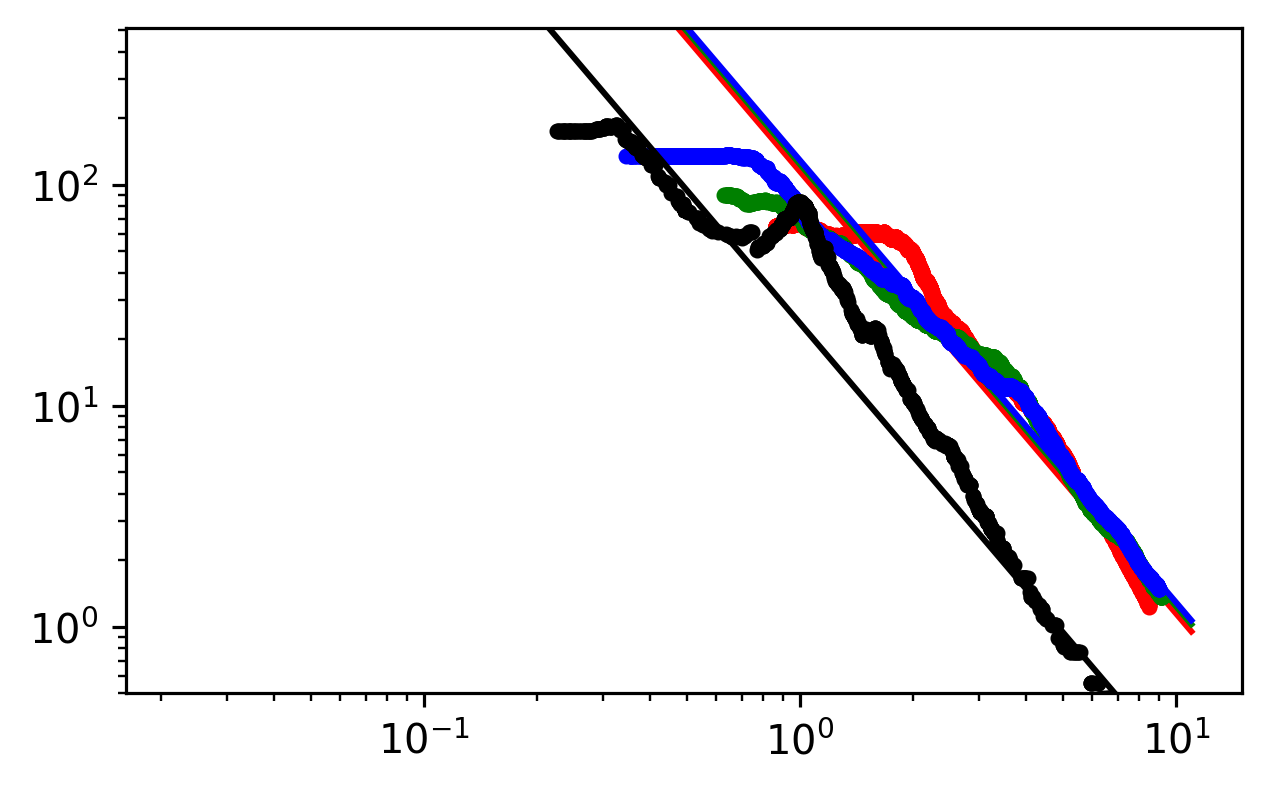

In [72]:
(fig,ax) = plt.subplots(1,1, figsize=(5,3), dpi=288)

eccrng = np.linspace(0, 11, 500)
for (clr,r) in zip(['r','g','b','k'], rs):
    #if clr != 'r': continue
    (ecc,cmag) = r.coords
    if len(r.x) == 3:
        (a,b,c) = r.x
    else:
        (a,b) = r.x
        c = 2
    ax.loglog(ecc, cmag, clr + '.')
    ax.loglog(eccrng, 1/HH91_vmag(eccrng, a, b, c), clr + '-')
ax.set_ylim([0.5,512])

In [116]:
def cmag_basics(sid, h, label):
    sub = cc.cmag.load_subject(sid)
    hem = sub.hemis[h]
    mask_nor2 = {
        'and': [
            ('eccentricity', 0, 12),
            ('visual_area', label)]}
    mask_r2 = {'and': mask_nor2['and'] + [('variance_explained', 0.04, 1)]}
    rdat = ny.retinotopy_data(hem)
    mask_ii = hem.mask(mask_r2)
    ecc = rdat['eccentricity'][mask_ii]
    srf = hem.prop('midgray_surface_area')
    totarea = np.sum(srf[hem.mask(mask_nor2)])
    srf = srf[mask_ii]
    ii = np.argsort(ecc)
    ecc = ecc[ii]
    srf = srf[ii] * totarea / np.sum(srf)
    return (ecc, srf)

$$ c_1 = \sqrt{\frac{a_M}{\pi \left(\log\left(\frac{c_2 + M}{c_2}\right) - \frac{M}{c_2 + M}\right)}} $$

In [164]:
def HH91_integral(x, a=17.3, b=0.75):
    xb = x + b
    return a**2 * np.pi * (np.log(xb / b) - x / xb)
def HH91_c1(totalarea, maxecc, b=0.75):
    mb = maxecc + b
    c1 = np.sqrt(totalarea / np.pi / (np.log(mb / b) - maxecc/mb))
def fit_cumarea_data(ecc, srf, params0=(17.3, 0.75), method=None):
    from scipy.optimize import minimize
    ecc = np.asarray(ecc, dtype=np.float64)
    srf = np.asarray(srf, dtype=np.float64)
    ii = np.argsort(ecc)
    ecc = ecc[ii]
    srf = srf[ii]
    cumsrf = np.cumsum(srf)
    def loss_vmag(params):
        params = list(params)
        params[1] = params[1]**2
        pred = HH91_integral(ecc, *params)
        error = (pred - cumsrf)
        return np.mean(error**2)
    params0 = list(params0)
    params0[1] = np.sqrt(params0[1])
    r = minimize(loss_vmag, params0, method=method)
    r.x[0] = abs(r.x[0])
    r.x[1] = r.x[1]**2
    r.coords = np.array([ecc,srf])
    return r
def fit_cumarea(sid, h, label):
    (ecc,srf) = cmag_basics(sid, h, label)
    if len(ecc) == 0:
        raise RuntimeError(f"no data found for {sid}:{h}:{label}")
    r = fit_cumarea_data(ecc, srf)
    r.coords = np.array([ecc, srf])
    return r

sub-wlsubj119 lh V1: a=20.63, b=1.601
sub-wlsubj119 lh V2: a=15.53, b=0.782
sub-wlsubj119 lh V3: a=13.86, b=0.563
sub-wlsubj119 lh V4: a= 8.20, b=0.105
sub-wlsubj119 rh V1: a=24.22, b=1.652
sub-wlsubj119 rh V2: a=17.11, b=0.920
sub-wlsubj119 rh V3: a=14.33, b=0.698
sub-wlsubj119 rh V4: a=12.52, b=1.045


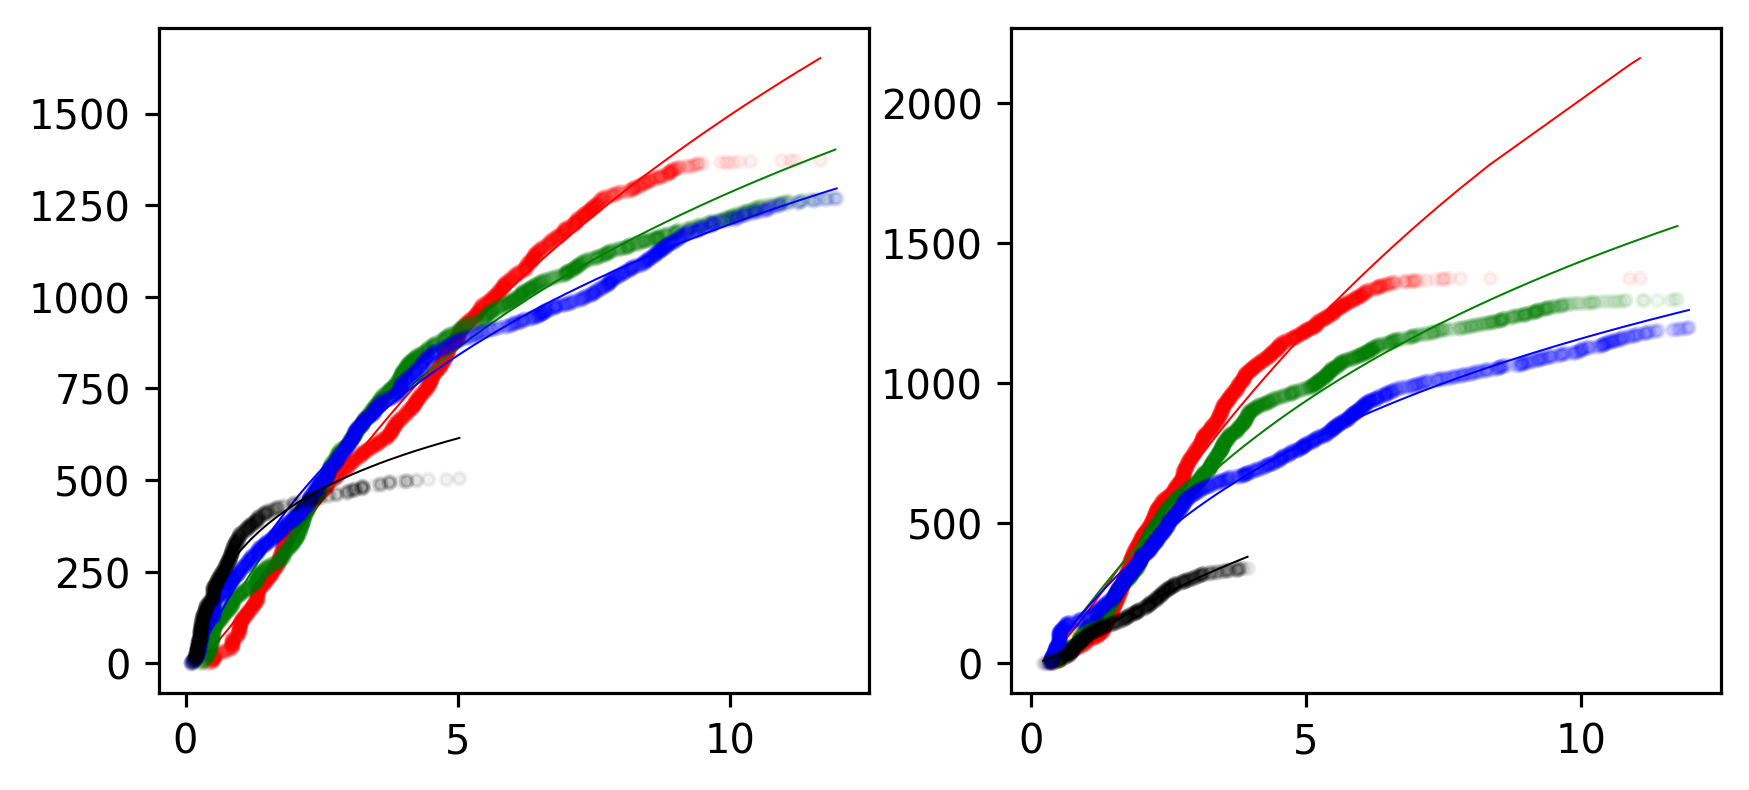

In [264]:
sid = sids[0]

(fig,axs) = plt.subplots(1,2, figsize=(7,3), dpi=288)
eccrng = np.linspace(0, 11, 500)

for (h,ax) in zip(['lh','rh'], axs):
    for (clr, lbl) in zip(['r','g','b','k'], [1,2,3,4]):
        r = fit_cumarea(sid, h, lbl)
        (ecc,srf) = r.coords
        (a,b) = r.x
        print(f"{sid:<13s} {h:2s} V{lbl}: a={a:5.2f}, b={b:5.3f}")
        ax.plot(ecc, np.cumsum(srf), clr + '.', lw=0.5, alpha=0.05)
        ax.plot(ecc, HH91_integral(ecc, a, b), clr + '-', lw=0.5)

In [167]:
df = dict(sid=[], h=[], label=[], a=[], b=[], loss=[])
for sid in sids:
    print(sid)
    for h in ['lh','rh']:
        for lbl in [1,2,3,4]:
            try:
                r = fit_cumarea(sid, h, lbl)
            except Exception as e:
                print(f"  - Skipping: {type(e)}")
                continue
            df['sid'].append(sid)
            df['h'].append(h)
            df['label'].append(lbl)
            df['a'].append(r.x[0])
            df['b'].append(r.x[1])
            df['loss'].append(r.fun)
HH91_params = pd.DataFrame(df)

sub-wlsubj119
sub-wlsubj127
sub-wlsubj136
sub-wlsubj137
sub-wlsubj143
sub-wlsubj144
sub-wlsubj145
sub-wlsubj146
sub-wlsubj147
sub-wlsubj148
sub-wlsubj149
sub-wlsubj150
sub-wlsubj151
sub-wlsubj152
sub-wlsubj153
sub-wlsubj154
sub-wlsubj155
sub-wlsubj156
sub-wlsubj157
sub-wlsubj158
sub-wlsubj159
sub-wlsubj160
sub-wlsubj161
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
sub-wlsubj162
sub-wlsubj163
sub-wlsubj164
sub-wlsubj165
sub-wlsubj166
sub-wlsubj167
sub-wlsubj168
sub-wlsubj170
  - Skipping: <class 'RuntimeError'>
  - Skipping: <class 'RuntimeError'>
  - Skipping: <class 'RuntimeError'>
  - Skipping: <class 'RuntimeError'>
sub-wlsubj171
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <clas

In [168]:
HH91_params

,sid,h,label,a,b,loss
0,sub-wlsubj119,lh,1,20.628879,1.601142,1022.214056
1,sub-wlsubj119,lh,2,15.528206,0.782424,1813.135205
2,sub-wlsubj119,lh,3,13.860489,0.563344,866.322427
3,sub-wlsubj119,lh,4,8.201607,0.105091,1111.134677
4,sub-wlsubj119,rh,1,24.220382,1.652452,5475.886536
...,...,...,...,...,...,...
271,sub-wlsubj176,lh,4,8.220372,0.182393,227.598830
272,sub-wlsubj176,rh,1,17.623738,0.990169,1690.159079
273,sub-wlsubj176,rh,2,13.477847,0.578217,1129.800821
274,sub-wlsubj176,rh,3,10.398639,0.398737,240.121487


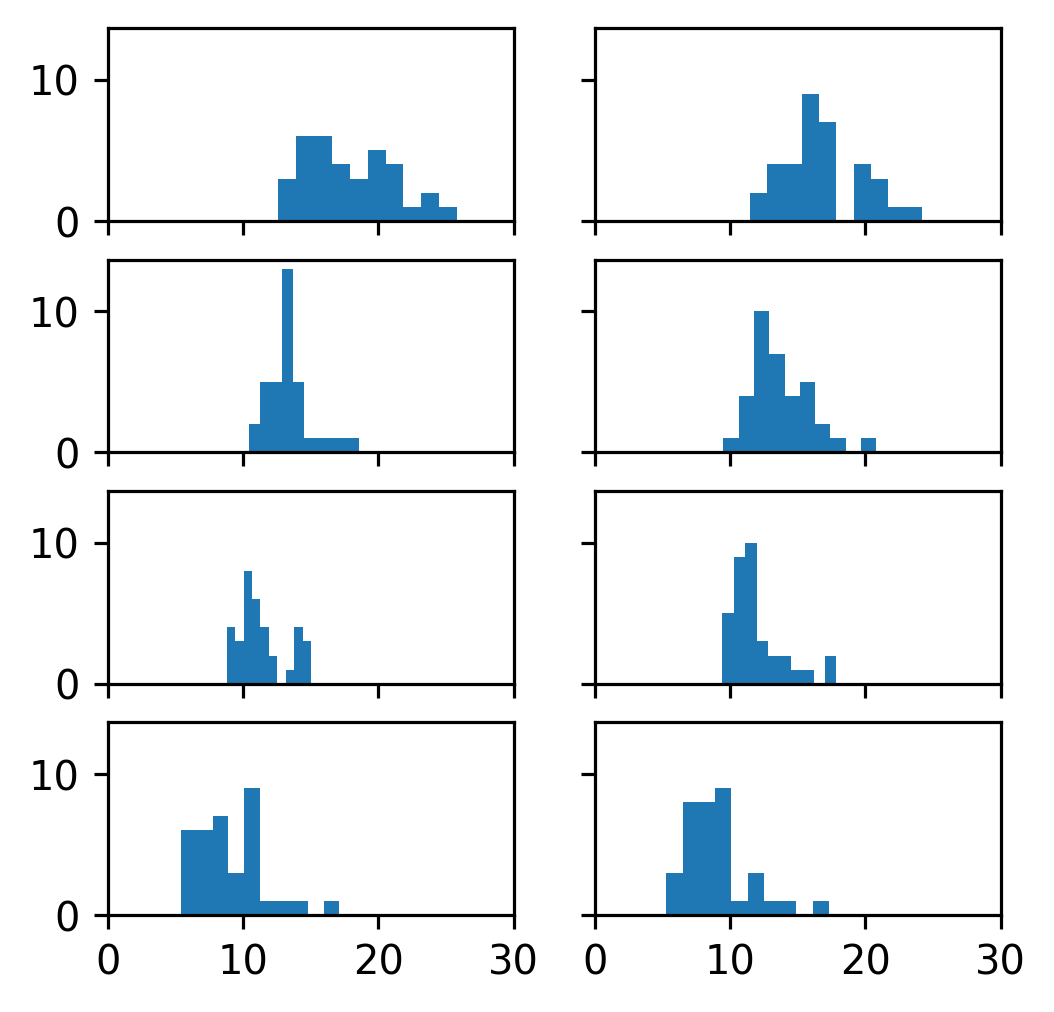

In [159]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        q = df2['a'].values
        ax.hist(q)
        ax.set_xlim([0,30])

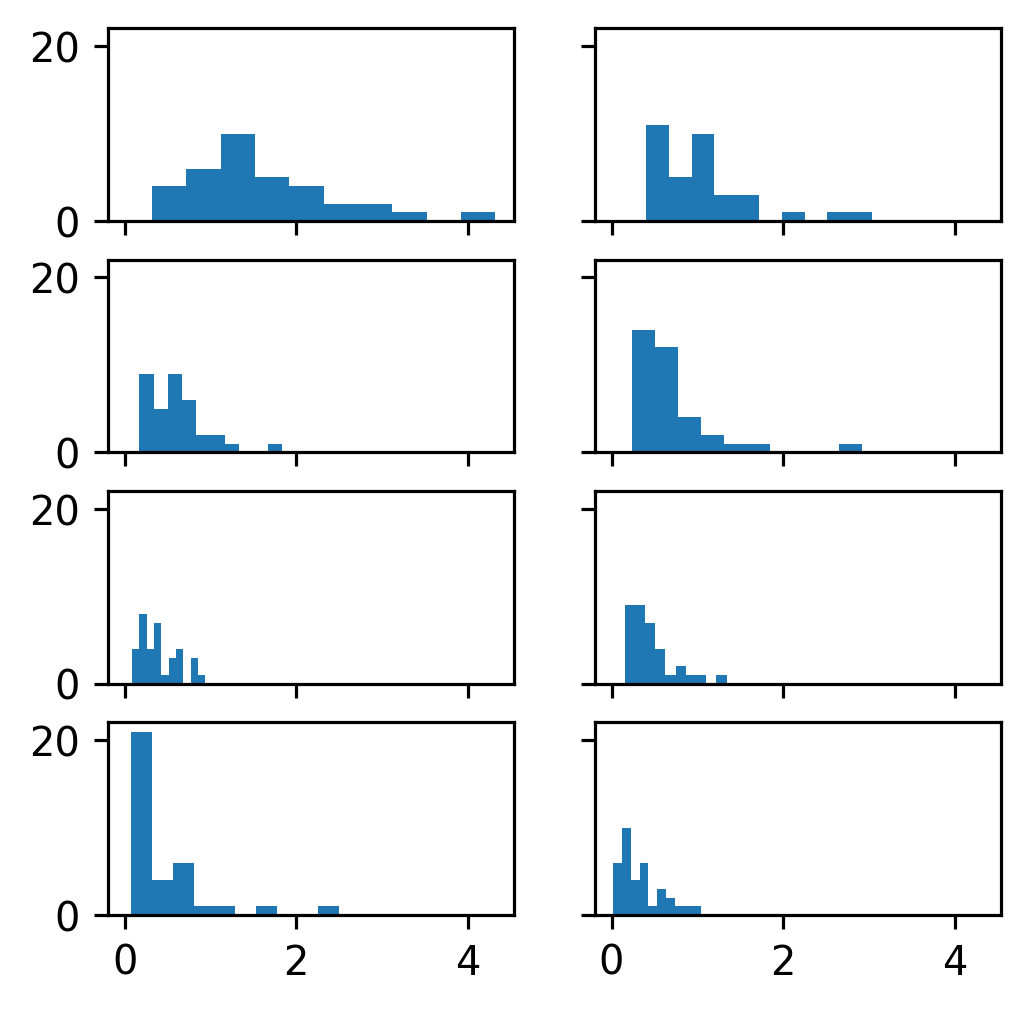

In [160]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        q = df2['b'].values
        ax.hist(q)
        #ax.set_xlim([0,2])

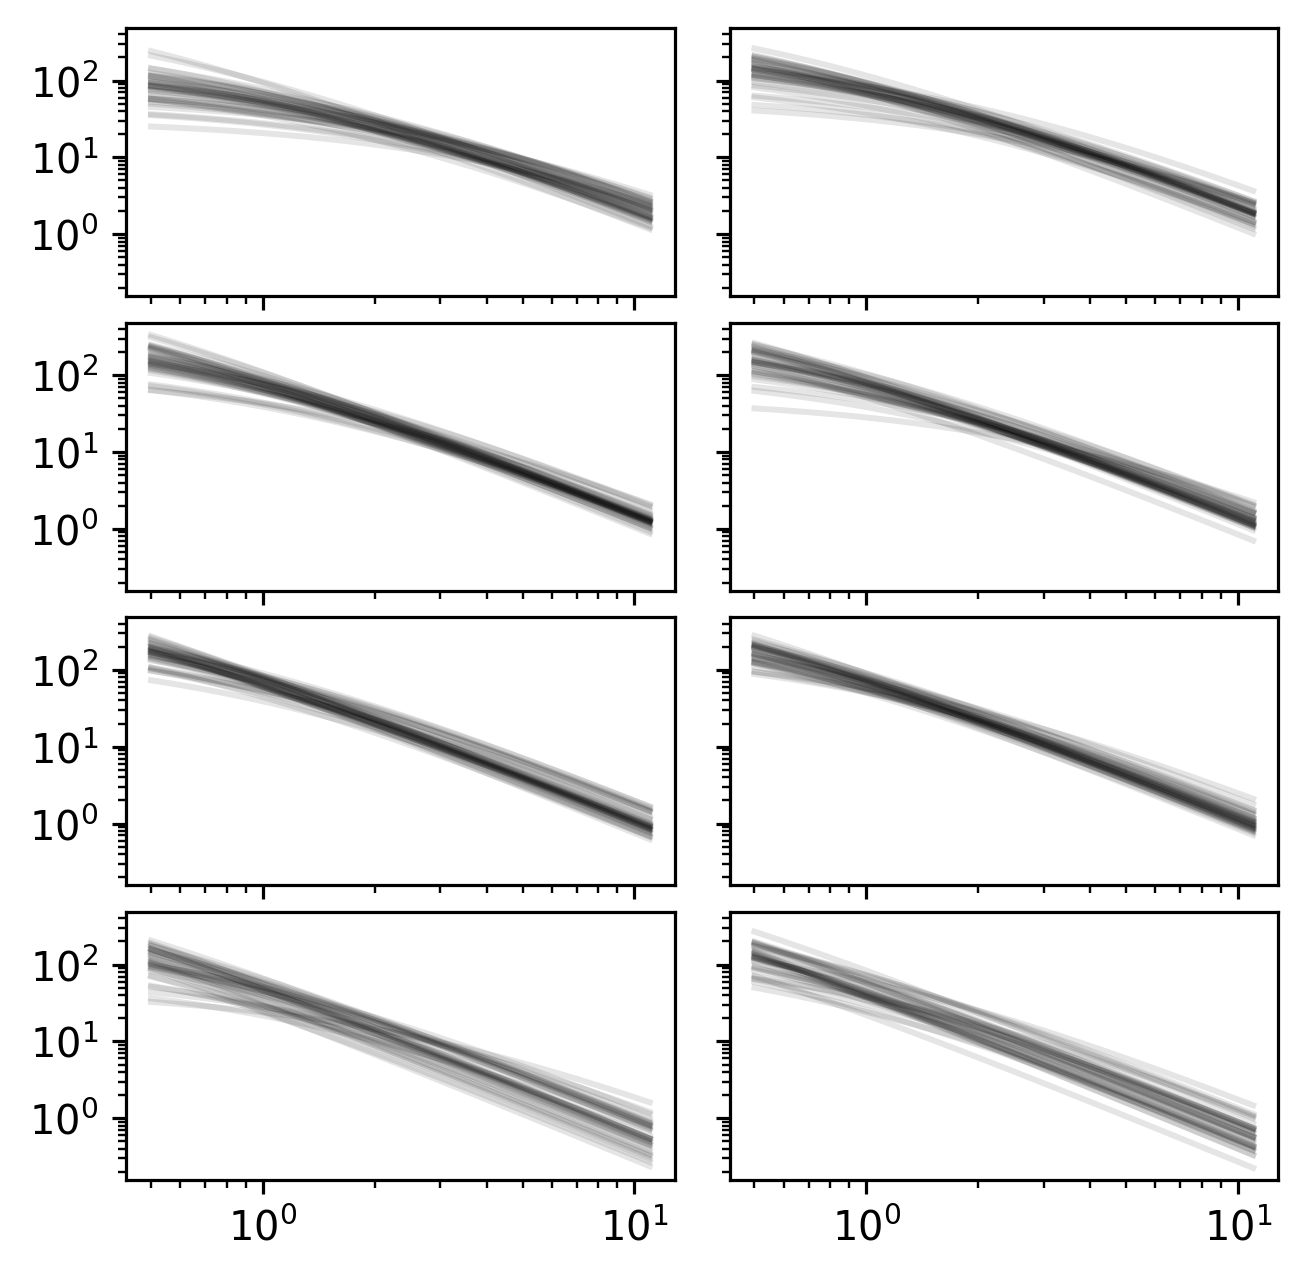

In [266]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
fig.subplots_adjust(0,0,1,1,0.1,0.1)
eccrng = np.linspace(0.5, 11, 500)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        for (a,b) in zip(df2['a'].values, df2['b'].values):
            ax.loglog(eccrng, (a / (b + eccrng))**2, 'k-', alpha=0.1)

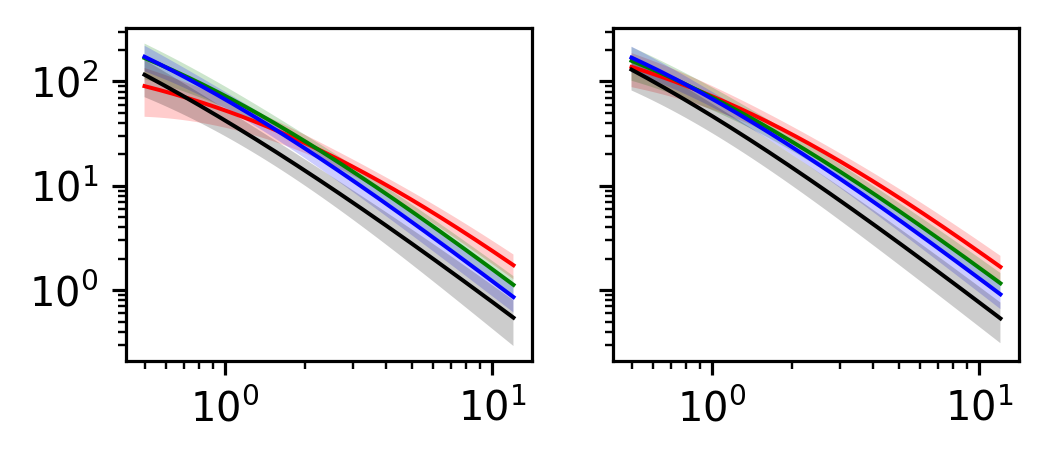

In [184]:
df = HH91_params
(fig,axs) = plt.subplots(1,2, figsize=(4,1.5), dpi=288, sharex=True, sharey=True)
eccrng = np.linspace(0.5, 12, 500)
for (lbl,clr) in zip([1,2,3,4], ['r','g','b','k']):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axs):
        df2 = df1[df1['h'] == h]
        a = df2['a'].values
        b = df2['b'].values
        m = (a[:,None] / (b[:,None] + eccrng[None,:]))**2
        mu = np.mean(m, axis=0)
        sd = np.std(m, axis=0)
        ax.fill_between(eccrng, mu - sd, mu + sd, edgecolor=None, facecolor=clr, alpha=0.2, zorder=-1)
        ax.loglog(eccrng, mu, clr+'-', lw=1)

**Below this point, I'm not sure that things are done correctly! Please check the code dealing with the crowding dataframe to make sure it is reasonable!**

In [193]:
crowd_df = pd.read_csv('/data/crowding/crowding_data_withID.csv')
crowd_df

,ID,FlankinDirection,Eccen_X,Eccen_Y,CrowdingDistance,Session,RadialEccentricity
0,sub-wlsubj153,radial,5.0,0.0,3.701109,1,5.0
1,sub-wlsubj153,radial,-5.0,-0.0,2.805407,1,5.0
2,sub-wlsubj153,radial,0.0,5.0,3.498309,1,5.0
3,sub-wlsubj153,radial,-0.0,-5.0,2.551906,1,5.0
4,sub-wlsubj153,radial,10.0,0.0,7.250118,1,10.0
...,...,...,...,...,...,...,...
475,sub-wlsubj005,radial,-0.0,-5.0,1.487204,2,5.0
476,sub-wlsubj005,radial,2.5,0.0,0.439401,2,2.5
477,sub-wlsubj005,radial,-2.5,-0.0,0.659102,2,2.5
478,sub-wlsubj005,radial,0.0,2.5,0.760502,2,2.5


In [253]:
df = HH91_params.copy()

df = df.merge(
    pd.DataFrame(dict(eccen=[2.5, 5.0, 10.0])),
    how='cross')

a = df['a']
b = df['b']
ecc = df['eccen']
df['cmag'] = (a / (ecc + b))**2
df['vmag'] = (a / (ecc + b))**-2

crowd_df = pd.read_csv('/data/crowding/crowding_data_withID.csv')
crowd_df.rename(
    columns=dict(ID='sid', Eccen_X='x', Eccen_Y='y', RadialEccentricity='eccen', CrowdingDistance='cd'),
    inplace=True)
crowd_df = crowd_df[crowd_df['y'] == 0]
crowd_df = crowd_df.groupby(['sid','x','y'])['cd'].apply(gmean).reset_index()
x = crowd_df['x'].values
crowd_df['h'] = np.array(['lh','rh'])[(x != 0).astype(int)]
crowd_df['eccen'] = np.abs(x)
crowd_df = crowd_df.drop(columns=['x','y'])
crowd_df = crowd_df[['sid', 'eccen', 'cd']]
crowd_df = crowd_df.groupby(['sid', 'eccen'])['cd'].apply(gmean).reset_index()

df = df.merge(crowd_df, on=['sid', 'eccen'])

In [256]:
ssdf

,sid,h,label,a,b,loss,eccen,cmag,vmag,cd
0,sub-wlsubj119,lh,1,20.628879,1.601142,1022.214056,2.5,25.301229,0.039524,0.384077
1,sub-wlsubj119,lh,1,20.628879,1.601142,1022.214056,5.0,9.765918,0.102397,0.999763
2,sub-wlsubj119,lh,1,20.628879,1.601142,1022.214056,10.0,3.161912,0.316264,1.731569
12,sub-wlsubj119,rh,1,24.220382,1.652452,5475.886536,2.5,34.021438,0.029393,0.384077
13,sub-wlsubj119,rh,1,24.220382,1.652452,5475.886536,5.0,13.255571,0.075440,0.999763
14,sub-wlsubj119,rh,1,24.220382,1.652452,5475.886536,10.0,4.320433,0.231458,1.731569


In [260]:
res = {1:[],2:[],3:[],4:[]}
for (sidtup,sdf) in df.groupby(['sid']):
    for h in ['lh','rh']:
        ssdf = sdf[sdf['h'] == h]
        for lbl in [1,2,3,4]:
            sssdf = ssdf[ssdf['label'] == lbl]
            x = np.sqrt(sssdf['vmag'].values)
            y = sssdf['cd'].values
            (rss,coef) = cc.regression.fit_and_evaluate(x, y)
            res[lbl].append(rss)

In [262]:
{k:np.mean(v) for (k,v) in res.items()}

{1: np.float64(0.5041128930443209),
 2: np.float64(0.3640139302827354),
 3: np.float64(0.33850525984539964),
 4: np.float64(0.32755666214741547)}

(array([[15.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
        [17.,  2.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.],
        [19.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.],
        [18.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.]]),
 array([3.03195890e-03, 3.45829366e-01, 6.88626774e-01, 1.03142418e+00,
        1.37422159e+00, 1.71701900e+00, 2.05981640e+00, 2.40261381e+00,
        2.74541122e+00, 3.08820862e+00, 3.43100603e+00]),
 <a list of 4 BarContainer objects>)

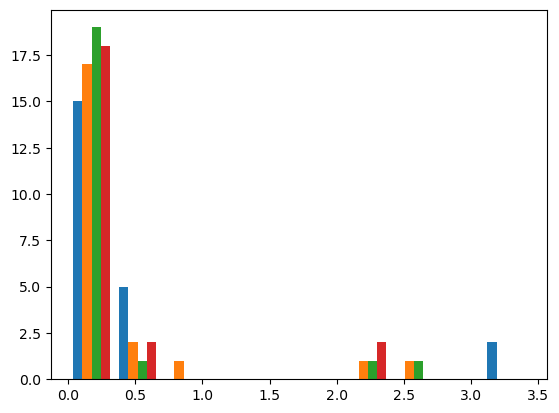

In [263]:
plt.hist(list(res.values()))